In [1]:
import numpy as np
import pandas as pd
import re
import glob

#to test with other folders, change this 
root_testing_folder = "REPORT_RUNS/"
operations = ["naive", "coalesced", "conflict-free"]

In [39]:
def file_paths(dataset_directory):
    paths = []
    print("loading:", dataset_directory)
    for x in glob.iglob(dataset_directory + "*.txt"):
        paths.append(x)
    return paths


def file_properties(path):
    print(path)
    list_of_matches = re.findall("(\d+)-(\d+)-(\d+) ?-(\d+)-(\d+).txt", path)
    arr = list_of_matches.pop()
    return int(arr[0]), int(arr[1]), int(arr[2]), int(arr[3]), int(arr[4])


def file_reader(str):
    print(str)
    list_of_matches = re.findall(
        "  copy +(\d+.\d+)\n +shared memory copy +(\d+.\d+)\n +naive transpose +(\d+.\d+)\n +coalesced transpose +(\d+.\d+)\n +conflict-free transpose +(\d+.\d+)\n", str)
    if not list_of_matches:#is empty
        return [0,0,0,0,0]
    else:
        arr = list_of_matches.pop()
        return [float(arr[0]), float(arr[1]), float(arr[2]), float(arr[3]), float(arr[4])]


def bandwidth_correction(row,column):
    return row[column]/8

In [40]:
def get_dataframe(data_path):
    paths = file_paths(data_path)
    print(paths)

    properties_list = []
    for path in paths:
        with open(path) as file:
            pow, iter, dtype, optimization, tile_dim = file_properties(path)
            print(pow, iter, dtype, optimization,tile_dim)
            file.seek(20)
            str = file.read()
            results = file_reader(str)
            properties_list.append([pow, iter, dtype, optimization,tile_dim]+ results)
    df = pd.DataFrame(properties_list, columns=[
                      "pow", "iteration", "dtype", "optimization", "tile_dim", "copy", "shared_copy", "naive", "coalesced", "conflict-free"])
    return df

In [41]:

def get_data_values(dataframe,column):
    max_pow = int(dataframe['pow'].max())
    element = []
    pow_list=range(1,max_pow+1)
    type_list= range(0,3)
    optimization_list = range(0,4)
    for o in optimization_list:
        element.append([])
        for dt in type_list:
            element[o].append([])
            element[o][dt].append([])
            element[o][dt].append([])
            element[o][dt].append([])
            
            for x in pow_list:
                max_y = dataframe.query(f'pow == {x} and dtype=={dt} and optimization=={o}')[column].max()
                element[o][dt][0].append(max_y)
                min_y = dataframe.query(f'pow == {x} and dtype=={dt} and optimization=={o}')[column].min()
                element[o][dt][1].append(min_y)
                element[o][dt][2].append((max_y+min_y)/2)

    return pow_list, type_list, max_pow, element

In [53]:
import matplotlib.pyplot as plt


def print_plots_tile_dim(dataframe, pow_range, tile_dim,operation="copy", title="####################"):
    df_sorted = dataframe.sort_values(by='pow')
    fig, axs = plt.subplots(2,2)
    colors = ["blue","red","magenta","green"]
    type_strings = ["integer","float","double"]
    pow_list = pow_range
    max_value= df_sorted["copy"].max()
    for x in range(0,3):
        bandwidhts = df_sorted.query(
            f'dtype=={x} and optimization=={0}and tile_dim=={tile_dim}and iteration==1')[operation].values
        axs[0, 0].plot(pow_list, bandwidhts, linewidth=1,color=colors[x],label = type_strings[x])
        axs[0,0].set_xticks(pow_list,[])
        axs[0,0].legend()
        bandwidhts = df_sorted.query(
            f'dtype=={x} and optimization=={1}and tile_dim=={tile_dim}and iteration==1')[operation].values

        axs[0, 1].plot(pow_list, bandwidhts, linewidth=1,color=colors[x],label = type_strings[x])


        axs[0,1].set_xticks(pow_list,[])
        
        bandwidhts = df_sorted.query(
            f'dtype=={x} and optimization=={2}and tile_dim=={tile_dim}and iteration==1')[operation].values

        axs[1, 0].plot(pow_list, bandwidhts, linewidth=1,color=colors[x],label = type_strings[x])
        axs[1, 0].set_xticks(pow_list,pow_list,rotation=270)

        bandwidhts = df_sorted.query(
            f'dtype=={x} and optimization=={2}and tile_dim=={tile_dim}and iteration==1')[operation].values

        axs[1, 1].plot(pow_list, bandwidhts, linewidth=1,color=colors[x],label = type_strings[x])

        axs[1, 1].set_xticks(pow_list, pow_list,rotation=270)
    
    
    axs[0, 0].axhline(y=max_value, color='g', linestyle='-')
    axs[0, 1].axhline(y=max_value, color='g', linestyle='-')
    axs[1, 0].axhline(y=max_value, color='g', linestyle='-')
    axs[1, 1].axhline(y=max_value, color='g', linestyle='-')

    axs[0, 0].set_title('No optimization')
    axs[0, 1].set_title('-01')
    axs[1, 0].set_title('-02')
    axs[1, 1].set_title('-03')
    axs[0, 0].set_ylabel("GB/s")
    axs[1, 0].set_ylabel("GB/s")
    axs[1, 0].set_xlabel('Power')
    axs[1, 1].set_xlabel('Power')
    """
     axs[0, 0].set_ylim([0, max_value])
    axs[1, 1].set_ylim([0, max_value])
    axs[1, 0].set_ylim([0, max_value])
    axs[0, 1].set_ylim([0, max_value]) """
    fig.suptitle(title)
    plt.show()

In [54]:
df_MSI=get_dataframe(root_testing_folder+"MSI/")
for op in ["copy", "shared_copy", "naive", "coalesced", "conflict-free"]:
    df_MSI[op] = df_MSI.apply(bandwidth_correction,column=op, axis=1)

df_MSI.to_csv("MSI.csv")
#df_MSI.replace([np.inf, -np.inf], 0, inplace=True)

# plot
#pow_list_MSI,type_list,max_pow, bandwidths_LBM = get_data_values(df_MSI,"bandwidth")

#print_plots(pow_list_MSI, type_list, bandwidths_LBM,measuring = "GB/s",title="Linear Bandwidth MSI")

loading: REPORT_RUNS/MSI/
['REPORT_RUNS/MSI/10-1-1-0-16.txt', 'REPORT_RUNS/MSI/11-1-2-3-32.txt', 'REPORT_RUNS/MSI/5-1-2-0-32.txt', 'REPORT_RUNS/MSI/8-1-0-2-32.txt', 'REPORT_RUNS/MSI/12-1-2-0-32.txt', 'REPORT_RUNS/MSI/8-1-0-3-64.txt', 'REPORT_RUNS/MSI/8-1-2-3-64.txt', 'REPORT_RUNS/MSI/5-1-0-3-64.txt', 'REPORT_RUNS/MSI/11-1-0-1-16.txt', 'REPORT_RUNS/MSI/5-1-1-3-16.txt', 'REPORT_RUNS/MSI/8-1-2-1-64.txt', 'REPORT_RUNS/MSI/8-1-1-1-16.txt', 'REPORT_RUNS/MSI/7-1-1-0-16.txt', 'REPORT_RUNS/MSI/13-1-0-2-16.txt', 'REPORT_RUNS/MSI/7-1-1-1-64.txt', 'REPORT_RUNS/MSI/13-1-1-2-64.txt', 'REPORT_RUNS/MSI/7-1-0-2-16.txt', 'REPORT_RUNS/MSI/7-1-1-3-64.txt', 'REPORT_RUNS/MSI/13-1-0-3-64.txt', 'REPORT_RUNS/MSI/7-1-1-0-64.txt', 'REPORT_RUNS/MSI/5-1-2-2-16.txt', 'REPORT_RUNS/MSI/11-1-1-1-64.txt', 'REPORT_RUNS/MSI/7-1-2-3-16.txt', 'REPORT_RUNS/MSI/10-1-0-2-16.txt', 'REPORT_RUNS/MSI/14-1-1-0-32.txt', 'REPORT_RUNS/MSI/8-1-1-1-64.txt', 'REPORT_RUNS/MSI/13-1-2-3-16.txt', 'REPORT_RUNS/MSI/14-1-0-2-16.txt', 'REPORT_R

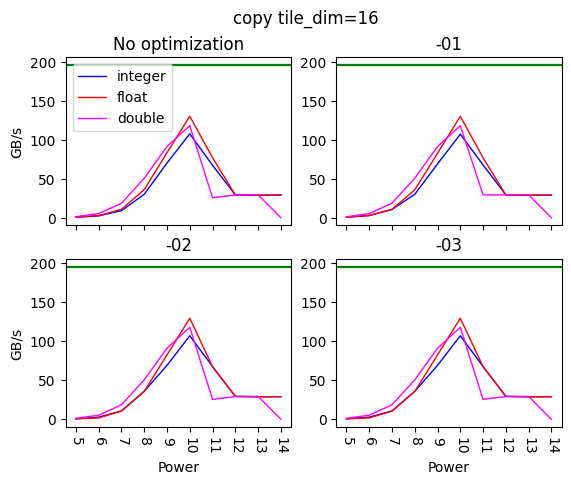

In [55]:
df_sorted1 = df_MSI.sort_values(by='pow')

print_plots_tile_dim(df_sorted1, range(5,15),16,operation="coalesced",title="copy tile_dim=16")

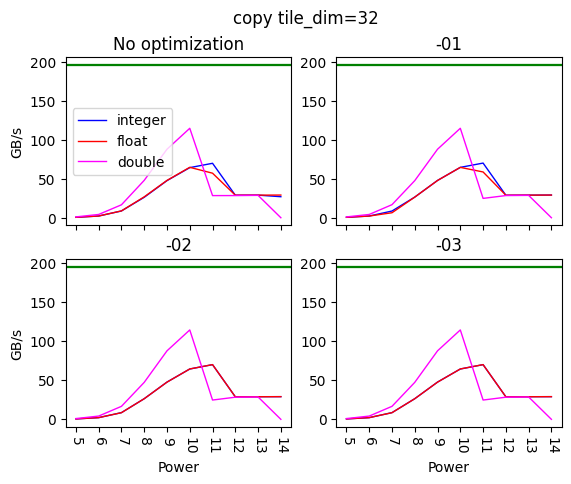

In [56]:
print_plots_tile_dim(df_sorted1, range(5, 15),32,operation="coalesced",title="4070 copy tile_dim=32")

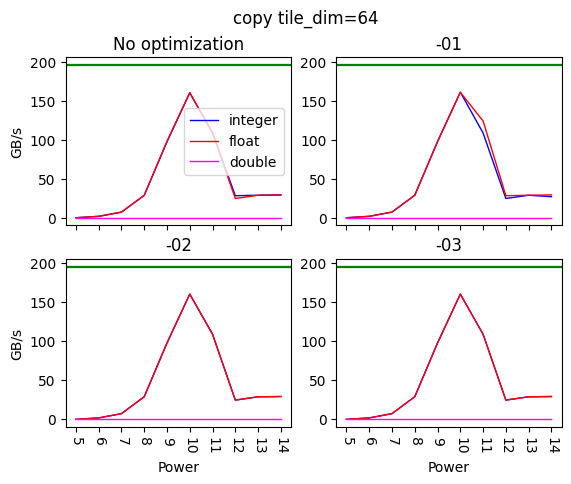

In [57]:
print_plots_tile_dim(df_sorted1, range(5, 15),64,operation="copy",title="copy tile_dim=64")

In [58]:
def print_plots(dataframe,dtype=0, title="####################"):
    df_sorted = dataframe.sort_values(by='pow')
    colors = ["blue", "red", "green", "magenta"]
    linestyle = ["solid", "dashed", "dotted", "dashdot"]
    fig, ax1 = plt.subplots()
    pow_list= range(df_sorted["pow"].min(),df_sorted["pow"].max()+1)
    max_value = df_sorted["copy"].max()

    
    for y,op in enumerate(operations):
        for x,tile_dim in enumerate([16,32,64]):
        
            bandwidhts = df_sorted.query(
                f'dtype=={dtype} and optimization=={0}and tile_dim=={tile_dim}and iteration==1')[op].values
            style_index = int(x/3)
            ax1.plot(pow_list, bandwidhts, color=colors[y], linestyle=linestyle[x],label =f"tile={tile_dim} {op}")

    ax1.legend()
    ax1.set_ylabel("GB/s")
    ax1.set_xticks(pow_list)

    fig.suptitle(title)
    plt.show()

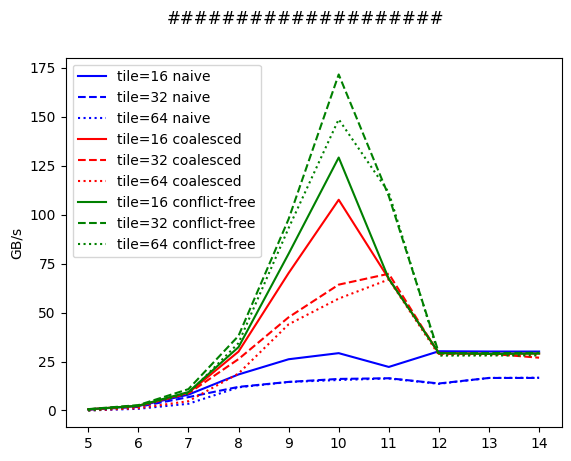

In [59]:
print_plots(df_MSI)

In [60]:
df_Marzola = get_dataframe(root_testing_folder+"Marzola/")
df_Marzola.to_csv("Marzola.csv")

loading: REPORT_RUNS/Marzola/
['REPORT_RUNS/Marzola/7-1-2 -1-64.txt', 'REPORT_RUNS/Marzola/8-1-0-2-32.txt', 'REPORT_RUNS/Marzola/11-1-0-1-16.txt', 'REPORT_RUNS/Marzola/5-1-2 -3-32.txt', 'REPORT_RUNS/Marzola/13-1-2 -0-64.txt', 'REPORT_RUNS/Marzola/13-1-0-2-16.txt', 'REPORT_RUNS/Marzola/7-1-0-2-16.txt', 'REPORT_RUNS/Marzola/10-1-2 -1-64.txt', 'REPORT_RUNS/Marzola/10-1-0-2-16.txt', 'REPORT_RUNS/Marzola/7-1-2 -0-16.txt', 'REPORT_RUNS/Marzola/14-1-0-2-16.txt', 'REPORT_RUNS/Marzola/5-1-0-3-16.txt', 'REPORT_RUNS/Marzola/6-1-2 -3-16.txt', 'REPORT_RUNS/Marzola/12-1-2 -1-32.txt', 'REPORT_RUNS/Marzola/14-1-2 -2-64.txt', 'REPORT_RUNS/Marzola/9-1-2 -0-32.txt', 'REPORT_RUNS/Marzola/5-1-0-2-32.txt', 'REPORT_RUNS/Marzola/9-1-0-0-64.txt', 'REPORT_RUNS/Marzola/5-1-2 -0-16.txt', 'REPORT_RUNS/Marzola/6-1-0-2-16.txt', 'REPORT_RUNS/Marzola/5-1-0-0-64.txt', 'REPORT_RUNS/Marzola/9-1-2 -3-32.txt', 'REPORT_RUNS/Marzola/8-1-2 -1-64.txt', 'REPORT_RUNS/Marzola/6-1-0-3-32.txt', 'REPORT_RUNS/Marzola/13-1-2 -2-16.txt

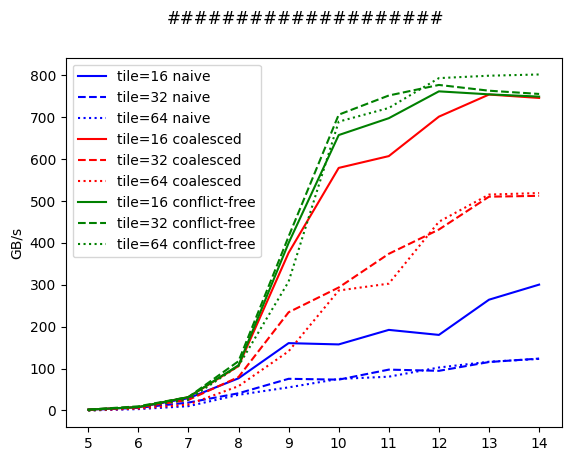

In [61]:
print_plots(df_Marzola)

In [64]:
def print_plots_double(dataframe1 ,title="####################"):
    df_sorted1 = dataframe1.sort_values(by='pow')
    #df_sorted2 = dataframe2.sort_values(by='pow')

    colors = ["blue", "red", "green", "magenta"]
    linestyle = ["solid", "dashed", "dotted", "dashdot"]
    fig, (ax1, ax2) = plt.subplots(2, 1, layout='constrained')
    pow_list = range(df_sorted1["pow"].min(), df_sorted1["pow"].max())
    max_value = df_sorted1["copy"].max()

    for y, op in enumerate(operations):
        for x, tile_dim in enumerate([16, 32, 64]):
            bandwidhts = df_sorted1.query(
                f'dtype=={0} and optimization=={0}and tile_dim=={tile_dim}and iteration==1')[op].values
            ax1.plot(pow_list, bandwidhts[:9],
                color=colors[y], linestyle=linestyle[x], label=f"tile={tile_dim} {op}")
    
    for y, op in enumerate(operations):
        for x, tile_dim in enumerate([16, 32, 64]):
            bandwidhts = df_sorted1.query(
                f'dtype=={2} and optimization=={0}and tile_dim=={tile_dim}and iteration==1')[op].values
            ax2.plot(pow_list, bandwidhts[:9],
                color=colors[y], linestyle=linestyle[x], label=f"tile={tile_dim} {op}")

    plt.legend(loc="upper left")
    """ 
    ax1.set_ylim([0, max_value])
    ax2.set_ylim([0, max_value]) """
    ax1.axhline(y=max_value, color='y', linestyle='-')
    ax2.axhline(y=max_value, color='y', linestyle='-')

    ax1.set_ylabel("GB/s")
    ax2.set_ylabel("GB/s")

    ax1.set_xticks(pow_list)
    ax2.set_xticks(pow_list)


    fig.suptitle(title)
    plt.show()

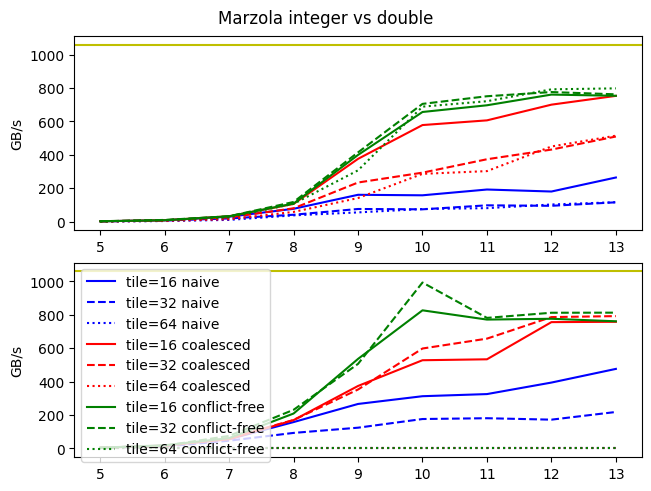

In [65]:
print_plots_double(df_Marzola,title="Marzola integer vs double")

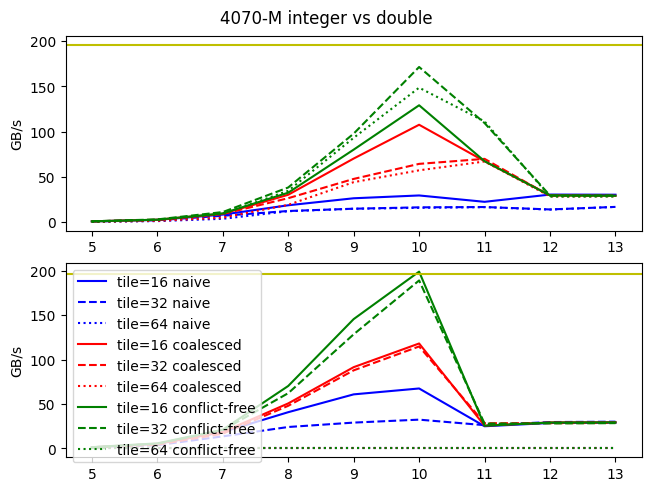

In [67]:
print_plots_double(df_MSI, title="4070-M integer vs double")

In [ ]:
def print_plots(pow_list, list_of_y1, list_of_y2, list_of_labels, alpha=.2, measuring1="", measuring2="", title="####################"):
    colors = ["blue", "red", "green", "magenta"]
    linestyle = ["solid", "dashed", "dotted", "dashdot"]
    fig, (ax1, ax2) = plt.subplots(2, 1, layout='constrained')
    max_x = max(pow_list)
    max_value = map(max, list_of_y1)
    for x in range(len(list_of_y1)):
        style_index = int(x/4)
        ax1.plot(pow_list, list_of_y1[x], color=colors[x %
                 4], linestyle=linestyle[style_index])

    print(list_of_y2)
    for x in range(len(list_of_y2)):
        style_index = int(x/4)
        ax2.plot(pow_list, list_of_y2[x], color=colors[x % 4],
                 linestyle=linestyle[style_index], label=list_of_labels[x])

    ax2.legend()
    ax1.set_ylabel(measuring1)
    ax2.set_ylabel(measuring2)

    fig.suptitle(title)
    plt.show()

In [ ]:
df_HP = get_dataframe(root_testing_folder+"Homework_runs_HP/")
pow_list,type_list,max_pow, bandwidths_LBH = get_data_values(df_HP,"bandwidth")
print_plots(pow_list, type_list, bandwidths_LBH,measuring = "GB/s",title="Linear Bandwidth HP")


loading: REPORT_RUNS/Homework_runs_HP/
[]


ValueError: cannot convert float NaN to integer

/tmp/ipykernel_95807/1820678608.py:22: RuntimeWarning: divide by zero encountered in scalar divide
  return (2**row["pow"]*2**row["pow"])*2*d_dim/(row["seconds"]*10**9)


26.2144


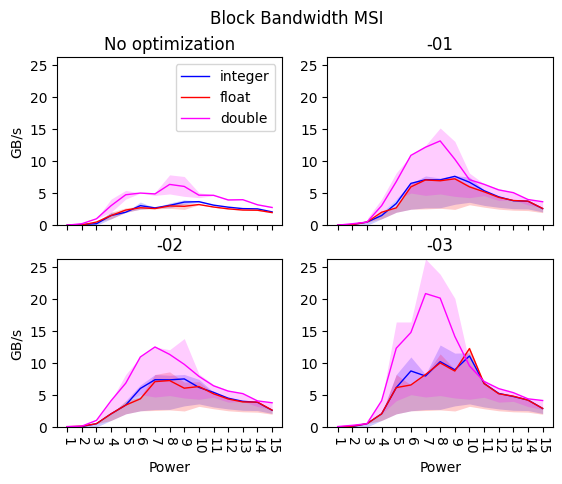

In [ ]:
df_MSI_block = get_dataframe(root_testing_folder+"Homework_runs_block/")
df_MSI_block.to_csv("pollo2.csv")
df_MSI_block.replace([np.inf, -np.inf], 0, inplace=True)

pow_list,type_list,max_pow, bandwidths_BBM = get_data_values(df_MSI_block,"bandwidth")
print_plots(pow_list, type_list, bandwidths_BBM,measuring = "GB/s",title="Block Bandwidth MSI")


7.489828571428571


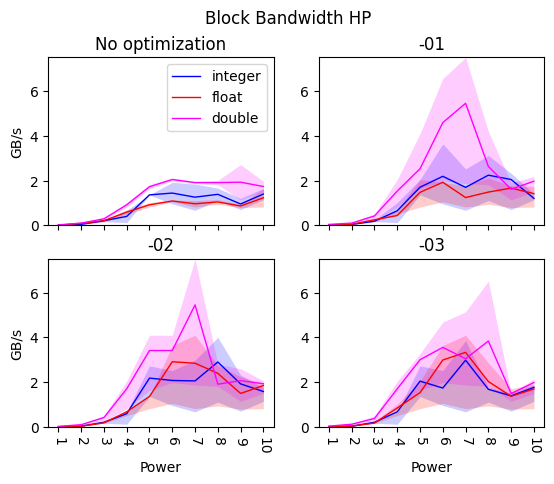

In [ ]:
df_HP_block = get_dataframe(root_testing_folder+"Homework_runs_block_HP/")
pow_list_HP,type_list,max_pow, bandwidths_BBH = get_data_values(df_HP_block,"bandwidth")
print_plots(pow_list_HP, type_list, bandwidths_BBH,measuring = "GB/s",title="Block Bandwidth HP")


In [ ]:
def file_properties_cache(path):
    list_of_matches = re.findall("cache_(\d+)-(\d+)-(\d+)-(\d+).txt", path)
    arr = list_of_matches.pop()
    return int(arr[0]),int(arr[1]),int(arr[2]),int(arr[3])

def file_properties_cache_HP(path):
    list_of_matches = re.findall("cache_(\d+)_(\d+)_(\d+)_(\d+).txt", path)
    arr = list_of_matches.pop()
    return int(arr[0]),int(arr[1]),int(arr[2]),int(arr[3])

def file_reader_D1_rates(str):
    list_of_matches = re.findall("D1 +miss rate: +(\d+\.\d+)% \( +(\d+\.\d+)% +\+ +(\d+\.\d+)% +\)", str)
    arr = list_of_matches.pop()
    return float(arr[0]),float(arr[1]),float(arr[2])

def file_reader_LLd_rates(str):
    list_of_matches = re.findall("LLd +miss rate: +(\d+\.\d+)% \( +(\d+\.\d+)% +\+ +(\d+\.\d+)% +\)", str)
    arr = list_of_matches.pop()
    return float(arr[0]),float(arr[1]),float(arr[2])

In [ ]:
def get_dataframe_cache(data_path):
    paths = file_paths(data_path)
    properties_list = []
    for path in paths:
        with open(path) as file:
            pow,iter,dtype,optimization = file_properties_cache(path)
            str = file.read()
            D1_tot,D1_rd,D1_wr = file_reader_D1_rates(str)
            LLd_tot,LLd_rd,LLd_wr = file_reader_LLd_rates(str)

            properties_list.append([pow,iter,dtype,optimization,D1_tot,D1_rd,D1_wr,LLd_tot,LLd_rd,LLd_wr])
    df = pd.DataFrame(properties_list,columns=["pow","iteration","dtype","optimization","D1_tot","D1_rd","D1_wr","LLd_tot","LLd_rd","LLd_wr"])

    return df

In [ ]:
def get_dataframe_cache_HP(data_path):
    paths = file_paths(data_path)
    properties_list = []
    for path in paths:
        with open(path) as file:
            pow,iter,dtype,optimization = file_properties_cache_HP(path)
            str = file.read()
            D1_tot,D1_rd,D1_wr = file_reader_D1_rates(str)
            LLd_tot,LLd_rd,LLd_wr = file_reader_LLd_rates(str)

            properties_list.append([pow,iter,dtype,optimization,D1_tot,D1_rd,D1_wr,LLd_tot,LLd_rd,LLd_wr])
    df = pd.DataFrame(properties_list,columns=["pow","iteration","dtype","optimization","D1_tot","D1_rd","D1_wr","LLd_tot","LLd_rd","LLd_wr"])

    return df

5.1


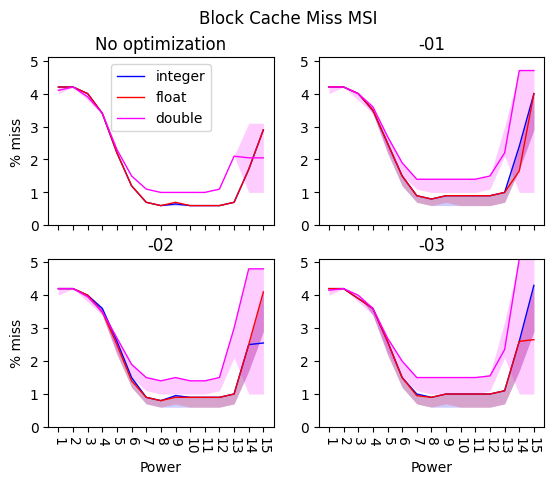

In [ ]:
df_MSI_cache_block = get_dataframe_cache(root_testing_folder+"cache_runs_block/")
pow_list,type_list,max_pow, percentage_BC1M = get_data_values(df_MSI_cache_block,"D1_tot")
print_plots(pow_list, type_list, percentage_BC1M,measuring = "% miss",title="Block Cache Miss MSI")

3.5


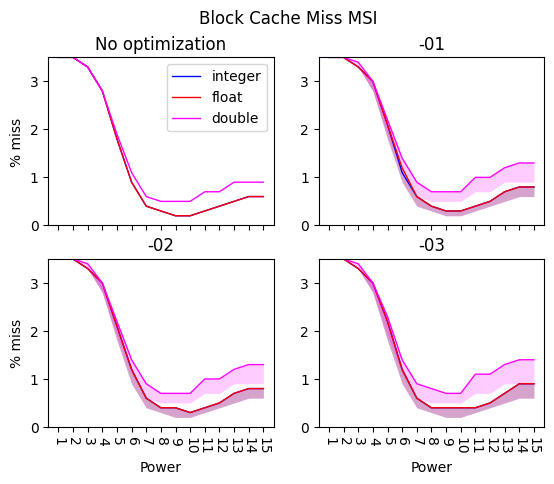

In [ ]:
pow_list,type_list,max_pow, percentage_BCLM = get_data_values(df_MSI_cache_block,"LLd_tot")
print_plots(pow_list, type_list, percentage_BCLM,measuring = "% miss",title="Block Cache Miss MSI")

4.2


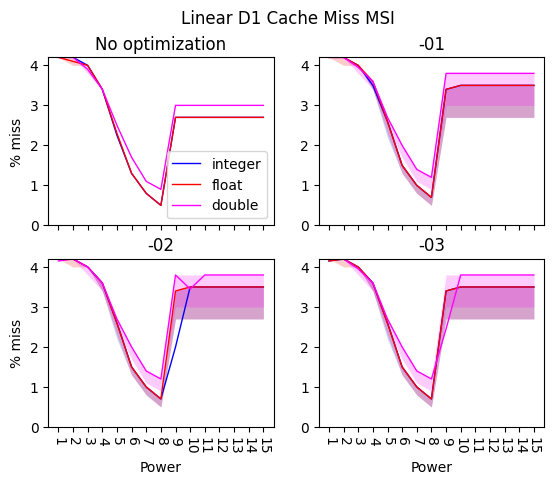

In [ ]:
df_MSI_cache = get_dataframe_cache(root_testing_folder+"cache_runs/")
pow_list,type_list,max_pow, percentage_LC1M = get_data_values(df_MSI_cache,"D1_tot")
print_plots(pow_list, type_list, percentage_LC1M,measuring = "% miss",title="Linear D1 Cache Miss MSI")

3.5


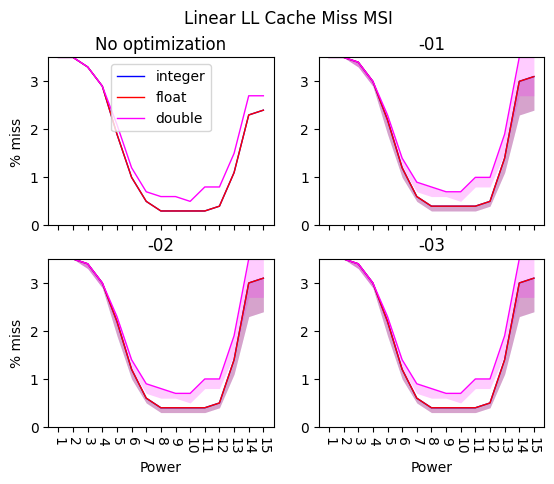

In [ ]:
pow_list,type_list,max_pow, percentage_LCLM = get_data_values(df_MSI_cache,"LLd_tot")
print_plots(pow_list, type_list, percentage_LCLM,measuring = "% miss",title="Linear LL Cache Miss MSI")

4.0


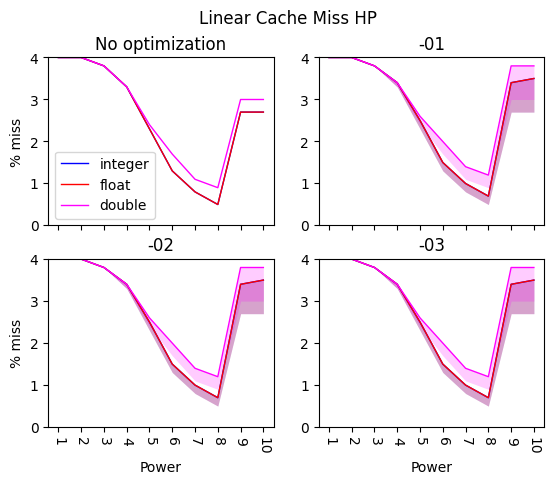

In [ ]:
df_HP_cache = get_dataframe_cache_HP(root_testing_folder+"cache_runs_HP/")
pow_list,type_list,max_pow, percentage_LC1H = get_data_values(df_HP_cache,"D1_tot")
print_plots(pow_list, type_list, percentage_LC1H,measuring = "% miss",title="Linear Cache Miss HP")

4.0


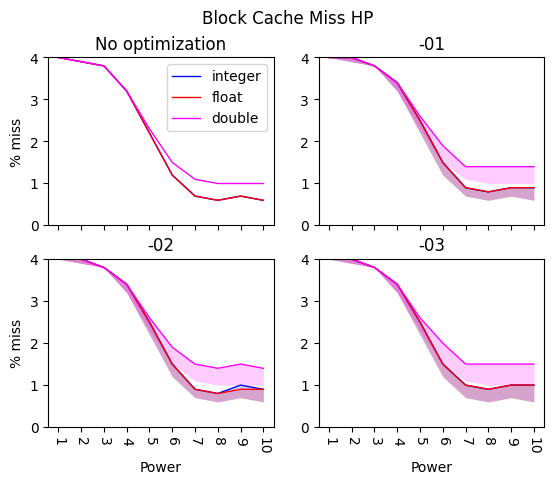

In [ ]:
df_HP_cache_block = get_dataframe_cache_HP(root_testing_folder+"cache_runs_block_HP/")
pow_list,type_list,max_pow, percentage_BC1H = get_data_values(df_HP_cache_block,"D1_tot")
print_plots(pow_list, type_list, percentage_BC1H,measuring = "% miss",title="Block Cache Miss HP")

In [ ]:
def get_middle_values(list_of_values,dtype):
    element = []
    for o in range(len(list_of_values)):
        element.append([])
        for x in range(len(list_of_values[o][dtype][2])):
            element[o].append(list_of_values[o][dtype][2][x])

    return element

[[4.0, 4.0, 3.8, 3.3, 2.4, 1.7, 1.1, 0.9, 3.0, 3.0], [4.0, 4.0, 3.8, 3.4, 2.6, 2.0, 1.4, 1.2, 3.8, 3.8], [4.0, 4.0, 3.8, 3.4, 2.6, 2.0, 1.4, 1.2, 3.8, 3.8], [4.0, 4.0, 3.8, 3.4, 2.6, 2.0, 1.4, 1.2, 3.8, 3.8], [4.0, 3.9, 3.8, 3.2, 2.3, 1.5, 1.1, 1.0, 1.0, 1.0], [4.0, 4.0, 3.8, 3.4, 2.6, 1.9, 1.4, 1.4, 1.4, 1.4], [4.0, 4.0, 3.8, 3.4, 2.6, 1.9, 1.5, 1.4, 1.5, 1.4], [4.0, 4.0, 3.8, 3.4, 2.6, 2.0, 1.5, 1.5, 1.5, 1.5]]


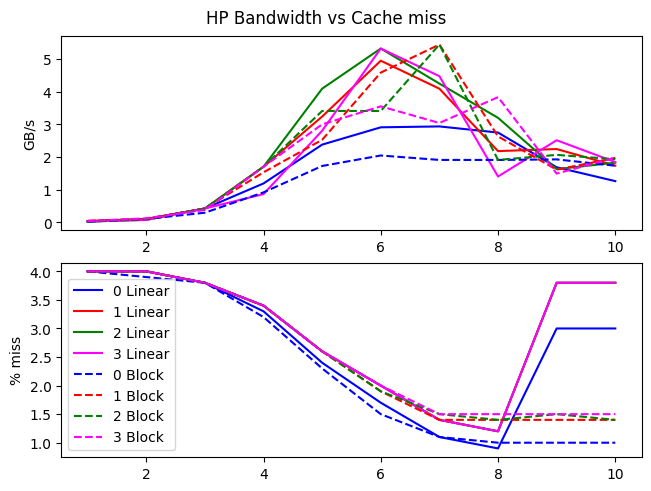

In [ ]:
y_list_bandwidths = []
LBH = get_middle_values(bandwidths_LBH,2)
BBH = get_middle_values(bandwidths_BBH,2)

for x in LBH:
    y_list_bandwidths.append(x)
for x in BBH:
    y_list_bandwidths.append(x)

y_list_percentage = []
LC1H = get_middle_values(percentage_LC1H,2)
BC1H = get_middle_values(percentage_BC1H,2)

for x in LC1H:
    y_list_percentage.append(x)
for x in BC1H:
    y_list_percentage.append(x)


labels =["0 Linear","1 Linear", "2 Linear","3 Linear","0 Block","1 Block", "2 Block","3 Block"]
print_plots(pow_list_HP,y_list_bandwidths, y_list_percentage, labels,measuring1="GB/s",measuring2="% miss",title="HP Bandwidth vs Cache miss")

[[3.5, 3.5, 3.3, 2.9, 2.1, 1.2, 0.7, 0.6, 0.6, 0.5, 0.8, 0.8, 1.5, 2.7, 2.7], [3.5, 3.5, 3.4, 3.0, 2.3, 1.4, 0.9, 0.8, 0.7, 0.7, 1.0, 1.0, 1.9, 3.5, 3.5], [3.5, 3.5, 3.4, 3.0, 2.3, 1.4, 0.9, 0.8, 0.7, 0.7, 1.0, 1.0, 1.9, 3.5, 3.5], [3.5, 3.5, 3.4, 3.0, 2.3, 1.4, 0.9, 0.8, 0.7, 0.7, 1.0, 1.0, 1.9, 3.5, 3.5], [3.5, 3.5, 3.3, 2.8, 1.9, 1.1, 0.6, 0.5, 0.5, 0.5, 0.7, 0.7, 0.9, 0.9, 0.9], [3.5, 3.5, 3.4, 3.0, 2.2, 1.4, 0.9, 0.7, 0.7, 0.7, 1.0, 1.0, 1.2, 1.3, 1.3], [3.5, 3.5, 3.4, 3.0, 2.2, 1.4, 0.9, 0.7, 0.7, 0.7, 1.0, 1.0, 1.2, 1.3, 1.3], [3.5, 3.5, 3.4, 3.0, 2.3, 1.4, 0.9, 0.8, 0.7, 0.7, 1.1, 1.1, 1.3, 1.4, 1.4]]


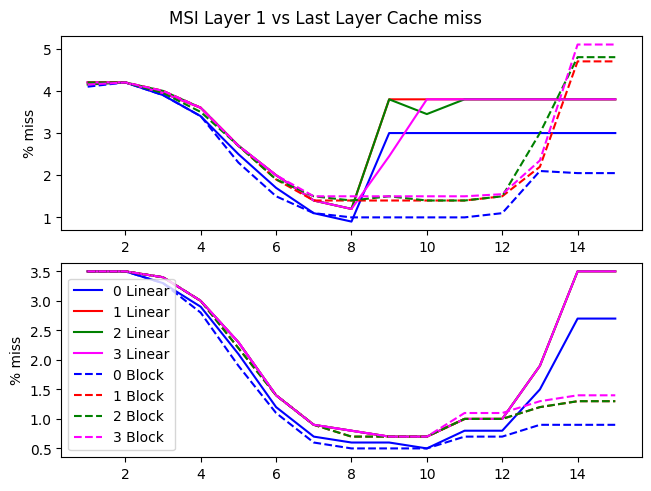

In [ ]:
y_list_bandwidths = []
a = get_middle_values(percentage_LC1M,2)
b = get_middle_values(percentage_BC1M,2)

for x in a:
    y_list_bandwidths.append(x)
for x in b:
    y_list_bandwidths.append(x)

y_list_percentage = []
c = get_middle_values(percentage_LCLM,2)
d = get_middle_values(percentage_BCLM,2)

for x in c:
    y_list_percentage.append(x)
for x in d:
    y_list_percentage.append(x)


labels =["0 Linear","1 Linear", "2 Linear","3 Linear","0 Block","1 Block", "2 Block","3 Block"]
print_plots(pow_list_MSI,y_list_bandwidths, y_list_percentage, labels,measuring1="% miss",measuring2="% miss",title="MSI Layer 1 vs Last Layer Cache miss")

[[0.013333333333333332, 0.048, 0.1792, 0.7168, 1.3653333333333333, 1.1299310344827587, 1.0839059595407328, 1.8624854496352943, 1.2076766682064606, 0.9089222671142725], [0.016, 0.064, 0.256, 0.5461333333333334, 1.4043428571428573, 2.0560313725490196, 1.9308455913978495, 2.080704136803722, 1.4753086471166639, 1.6015107307457817], [0.016, 0.064, 0.384, 0.3618133333333333, 2.048, 1.8045314685314684, 2.673847409220726, 2.137220541203374, 1.6593883722021492, 1.7396252870602549], [0.016, 0.064, 0.21333333333333332, 0.8533333333333333, 2.1845333333333334, 2.3525743589743593, 2.3710873533246417, 2.765612268640931, 1.7551798149498294, 1.472152114185557], [0.013333333333333332, 0.096, 0.21333333333333332, 0.5973333333333333, 0.9216, 1.0934816462736374, 0.9675659311374054, 1.0497412231614875, 0.8705668146582763, 1.235320439435065], [0.016, 0.05333333333333333, 0.256, 0.4437333333333333, 1.479111111111111, 1.927529411764706, 1.2457095337095336, 1.4896131161503248, 1.6675020060888324, 1.421055104879

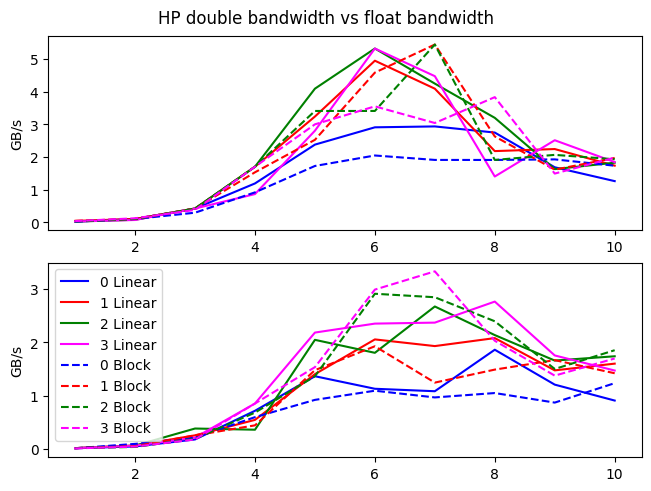

In [ ]:
y_list_bandwidths = []
a = get_middle_values(bandwidths_LBH,2)
b = get_middle_values(bandwidths_BBH,2)

for x in a:
    y_list_bandwidths.append(x)
for x in b:
    y_list_bandwidths.append(x)

y_list_bandwidths2 = []
a = get_middle_values(bandwidths_LBH,1)
b = get_middle_values(bandwidths_BBH,1)

for x in a:
    y_list_bandwidths2.append(x)
for x in b:
    y_list_bandwidths2.append(x)



labels =["0 Linear","1 Linear", "2 Linear","3 Linear","0 Block","1 Block", "2 Block","3 Block"]
print_plots(pow_list_HP,y_list_bandwidths, y_list_bandwidths2, labels,measuring1="GB/s",measuring2="GB/s",title="HP double bandwidth vs float bandwidth")